### Libraries

In [42]:
import sys
import pathlib

# Get project root (parent of generation/)
project_root = pathlib.Path().resolve().parent
sys.path.insert(0, str(project_root))

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

# Iteration 1

In [3]:
import json
import numpy as np
from scripts.utils.helpers import sys_params_gen as params_gen
from scripts.utils.helpers import initial_conditions_gen as ic_gen
from scripts.data_generation.binder import Binder  
from scripts.data_generation.tsdg import Sistema  
import os
import time

In [8]:
file_path = '/home/think/Desktop/TESIS/test_runs/templates/global_test.json'
destination_path = "/home/think/Desktop/TESIS/test_runs"

In [13]:
def genesis_bulk_global(file_path, destination_path):

    with open(file_path, 'r') as file:
        config = json.load(file)
    # Control variables
    config['run_mode']
    warden = config['warden']
    shared_parameters = config['shared_parameters']
    models = config['models']

    # Extract the variables we need from the shared_parameters
    test_number = shared_parameters["test_number"]
    number_of_child_systems = shared_parameters["number_of_child_systems"]  
    #t_span = shared_parameters["t_span"]  
    #t_span = (t_span[0], t_span[1]) 
    t_span = tuple(shared_parameters["t_span"])
    num_points = shared_parameters["num_points"]  
    initial_conditions = shared_parameters["initial_conditions"]  
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    # Initial conditions for each system
    systems_initial_dict = ic_gen(initial_conditions, number_of_child_systems)

    # Here we decide which model is allowed to be muahahaha
    for key, value in warden.items():
        if value == True:
            parent_model = key
            # Extracting parameters (and them ranges)
            params = {
                key: {"min": value[0], "max": value[1]} 
                for key, value in models[key]["params"].items()
                }
            # Parameters for each system
            systems_params_dict = params_gen(params, number_of_child_systems)
            for i, ((_, v1), (_, v2)) in enumerate(zip(systems_params_dict.items(), systems_initial_dict.items())):
            
                # Initialize the Binder object for dynamic function import
                binder = Binder(module_name=f"systems.{parent_model}", 
                                function_name=parent_model, 
                                params=v1)
                
                # Import the module
                binder.import_module()
                
                # Prepare the function
                fixed_function = binder.fixer()
                
                if fixed_function:  
                    # Now we have the fixed function ready, so we can pass it to Sistema
                    sistema = Sistema(f=fixed_function, 
                                        y0=v2, 
                                        t=t_eval, 
                                        metodo='RK45')
                    
                    # Solve the system
                    sistema.resolver()
                    # Display a cutie plot
                    sistema.graficar(tipo='series', guardar=False, show_plot=True)
                    # Get the DataFrame for the solution
                    ruta = os.path.join(f"{destination_path}",f"test_{test_number}",f"{parent_model}" ,f"{parent_model}_{i}.csv")
                    #os.makedirs(os.path.dirname(ruta), exist_ok=True)  # Create directory if it doesn't exist
                    #sistema.csv_or_dataframe(ruta)
                    #sistema.atractor_animation()
                    print(f'{parent_model}_{i} has been generated \n at {ruta}')

In [ ]:
genesis_bulk_global(file_path,destination_path)

In [ ]:
from utils.crawler import crawler

# Iteration 2

### Experiment Folder

In [44]:
logger_params = {
    "main_folder": "/home/think/Desktop/BODEGA_AURRERA",
    "experiment_name": "Avances",
    "date": "2025-09-01",
    "iteration": 2,
    "description": (
        "Se va a estudiar el clustering, la prediccion y transfer learning "
        " difiere en los siguinentes 2 conjuntos: "
        "- Mismos params, diferentes i.c."
        "- Diferentes params, mismas i.c"
        "para los modelos Rossler, Lorenz63, Aizawa, Sprott y Dadras "
        "con 4 sistemas cada uno"
    )
}

In [45]:
from pathlib import Path

def create_experiment_folder(logger_params):
    # Extract parameters
    main_folder = Path(logger_params["main_folder"])
    exp_name = logger_params["experiment_name"]
    date = logger_params["date"]
    iteration = logger_params["iteration"]
    description = logger_params["description"]

    # Build experiment folder name
    folder_name = f"{exp_name}_{date}_iter{iteration}"
    exp_folder = main_folder / folder_name

    # Create folder (including parents if missing)
    exp_folder.mkdir(parents=True, exist_ok=True)

    # Write manifesto.txt
    manifesto_path = exp_folder / "manifesto.txt"
    with open(manifesto_path, "w", encoding="utf-8") as f:
        f.write(description)

    return exp_folder, manifesto_path


In [46]:
exp_folder, manifesto_path = create_experiment_folder(logger_params)
print(f"Experiment folder created at: {exp_folder}")
print(f"Manifesto written to: {manifesto_path}")

Experiment folder created at: /home/think/Desktop/BODEGA_AURRERA/Avances_2025-09-01_iter2
Manifesto written to: /home/think/Desktop/BODEGA_AURRERA/Avances_2025-09-01_iter2/manifesto.txt


### Generacion de Series de Tiempo de Rossler

In [16]:
from scripts.data_generation.binder import Binder
from scripts.utils.plastic_surgeon import from_sol_to_df

In [17]:
# Parameters
a = 0.2
b = 0.2
c = 5.7
params = (a,b,c)

# Use Binder to fix parameters
binder = Binder("scripts.systems.rossler", "rossler", params)
binder.import_module()
rossler_fixed = binder.fixer()  # Partially applied function

In [18]:
t_span = (0, 105)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

In [19]:
initial_conditions = {
    "sample_0": [0.1, 0.1, 0.1],
    "sample_1": [0.2, 0.2, 0.2],
    "sample_2": [0.5, 0.5, 0.5],
    "sample_3": [1.0, 0.0, -0.5],
}

# samples = {}

# for name, y0 in initial_conditions.items():
#     sol = solve_ivp(rossler_fixed, t_span, y0, method="RK45", t_eval=t_eval)
#     samples[name] = from_sol_to_df(sol, 3, "D")

In [20]:
# --- Step 2: create a subfolder for Rossler samples ---
rossler_folder = exp_folder / "rossler"
rossler_folder.mkdir(exist_ok=True)

# --- Step 3: save each sample as .h5 ---
for name, y0 in initial_conditions.items():
    sol = solve_ivp(rossler_fixed, t_span, y0, method="RK45", t_eval=t_eval)
    df = from_sol_to_df(sol, 3, "D")
    
    sample_path = rossler_folder / f"{name}.h5"
    df.to_hdf(sample_path, key="data", mode="w")  # using pandas HDF5 format

### Caso 1: Same params, diff i.c.
Generalizando generacion para Rossler, Lorenz63, Aizawa, Sprott, Dadras

In [32]:
t_span = (0, 105)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

In [ ]:
systems = {
    "rossler": (0.2, 0.2, 5.7),
    "lorenz63": (10, 28, 8/3),
    "aizawa": (0.95, 0.7, 0.6, 3.5, 0.25, 0.1),
    "sprott": (2.07, 1.79),
    "dadras" : (3, 2.7, 1.7, 2, 9)
}

In [50]:
def frange(start, stop, step):
    while start <= stop:
        yield round(start, 10)  # Avoid floating-point errors
        start += step

def initial_conditions_gen(initial_conditions, number_of_child_systems):

  child_initial_conditions_bag = {}

  for key, value in initial_conditions.items():
    # Retrieve the dynamically created min and max values from the global namespace
    min_value = value["min"]
    max_value = value["max"]
    step = (max_value - min_value) / number_of_child_systems
    gen = frange(min_value, max_value, step)
    child_initial_conditions_bag.update({f"{key}": np.fromiter(gen, dtype=float)})

  systems_initial_dict = {}
  w = []
  for value in child_initial_conditions_bag.values():
    w.append(len(value))
  for i in range(min(w)):
    y = []
    for key,value in child_initial_conditions_bag.items():
      y.append(value[i])
    systems_initial_dict[f"initial_condition_{i}"] = y
  
  return systems_initial_dict

In [53]:
initial_conditions = {
    "x": {"min": 0.1, "max": 1.0},
    "y": {"min": 0.1, "max": 1.0},
    "z": {"min": 0.1, "max": 2.0},
}
number_of_child_systems = 4

In [ ]:
for model_name, base_params in systems.items():
    
    # We create the function with the parameters using Binder given the model name and the params
    binder = Binder(f"scripts.systems.{model_name}", model_name, base_params)
    binder.import_module()
    system_func = binder.fixer()
    
    # We create the folder where we will store the .csv files
    system_folder = Path(exp_folder) / model_name
    system_folder.mkdir(exist_ok=True)
        
    # Now we generate the initial conditions
    ic_case_1 = initial_conditions_gen(initial_conditions, number_of_child_systems)
    case_folder = system_folder / "1"
    case_folder.mkdir(exist_ok=True)
    
    #for i, (_, y0) in ic_case_1.items():
    for i, (_, y0) in enumerate(ic_case_1.items()):
        name = f"{model_name}_sample_{i}"
        sol = solve_ivp(system_func, t_span, y0, method="RK45", t_eval=t_eval)
        df = from_sol_to_df(sol, len(y0), "D") # fix this!!!
        df.to_csv(case_folder / f"{name}.csv", index=True)

### Caso 2: Diff params, same i.c.

In [125]:
systems =  {
    
      "aizawa" : {
        "params": {
        "a": [0.95, 1.95],
        "b": [0.7, 1.7],
        "c": [0.6, 1.6],
        "d": [3.5,4.5],
        "e": [0.25,1.25],
        "f": [0.1,1.1]  
     }
    },
    
      "dadras" : {"params": {
        "a": [3, 4],
        "b": [2.7, 3.7],
        "c": [1.7, 2.7],
        "d": [2,3],
        "e": [9,10]
     }
    },
      "lorenz63": {
      "params": {
        "sigma": [10, 15],
        "beta": [2.66666666, 7],
        "rho": [28.5, 70]
      }
    },
      "rossler" : {
      "params": {
        "a": [0.2, 0.4],
        "b": [0.2, 0.4],
        "c": [5.7, 5.9]
      } 
    },
      "sprott" : {
      "params": {
        "a": [2.07, 3.07],
        "b": [1.79, 2.79]
      } 
      }
}

In [115]:
initial_conditions = {
    "x": [0.1],
    "y": [0.1],
    "z": [0.1],
}
number_of_child_systems = 4

In [107]:
def sys_params_gen(params, number_of_child_systems):

  child_parameters_bag = {}

  for key, value in params.items():
      min_value = value["min"]
      max_value = value["max"]
      step = (max_value - min_value) / number_of_child_systems
      child_parameters_bag[key] = list(frange(min_value, max_value, step))

  systems_params_dict = {}

  y = []
  for value in child_parameters_bag.values():
    y.append(len(value))
  for i in range(min(y)):
    y = []
    for key,value in child_parameters_bag.items():
      y.append(value[i])
    systems_params_dict[f"system_{i}_params"] = tuple(y) 
  
  return systems_params_dict  

In [126]:
for model_name, model_params in systems.items():
    
    # we already have a single initial condition for all the systems
    y0 = [v[0] for v in initial_conditions.values()]

    # we first extract the values for the first model
    params_v1 = model_params["params"]   
    # we make them ranges to feed the generator
    params_v2 = {
        key: {"min": value[0], "max": value[1]} 
        for key, value in params_v1.items()
        }
    # we generate the parameters bag
    systems_params_dict = sys_params_gen(params_v2, number_of_child_systems)


    # We create the folder where we will store the .csv files
    system_folder = Path(exp_folder) / model_name
    system_folder.mkdir(exist_ok=True)    
    case_folder = system_folder / "2"
    case_folder.mkdir(exist_ok=True)
    
    for i,(_, single_params) in enumerate(systems_params_dict.items()):
        
        # We create the function with the parameters using Binder given the model name and the params
        binder = Binder(f"scripts.systems.{model_name}", model_name, single_params)
        binder.import_module()
        system_func = binder.fixer()

        # We solve the fucntion and save the file in the correspondent folder 
        name = f"{model_name}_sample_{i}"
        sol = solve_ivp(system_func, t_span, y0, method="RK45", t_eval=t_eval)
        df = from_sol_to_df(sol, len(y0), "D") # fix this!!!
        df.to_csv(case_folder / f"{name}.csv", index=True)

### Just Checking

In [21]:
import pandas as pd
from pathlib import Path

def load_samples(exp_folder, system_name):
    """
    Load all .h5 files from a given system folder inside the experiment folder.
    
    Args:
        exp_folder (Path or str): Path to the experiment folder.
        system_name (str): Name of the system folder (e.g., "rossler").
        
    Returns:
        dict: {sample_name: DataFrame}
    """
    exp_folder = Path(exp_folder)
    system_folder = exp_folder / system_name
    samples = {}

    if not system_folder.exists():
        raise FileNotFoundError(f"System folder '{system_name}' does not exist.")

    for file in system_folder.glob("*.h5"):
        sample_name = file.stem  # filename without extension
        df = pd.read_hdf(file, key="data")
        samples[sample_name] = df

    return samples


In [22]:
# Load all Rossler samples
rossler_samples = load_samples(exp_folder, "rossler")

# Access a specific sample
df0 = rossler_samples["sample_0"]

# Do anything with df0 like a normal pandas DataFrame
print(df0.head())

                   y     exo_1     exo_2
date                                    
1970-01-01  0.100000  0.100000  0.100000
1970-01-02  0.097913  0.101250  0.096328
1970-01-03  0.095850  0.102482  0.092863
1970-01-04  0.093809  0.103694  0.089594
1970-01-05  0.091790  0.104888  0.086511


In [26]:
import matplotlib.pyplot as plt

def plot_3d(df):
    """
    Plot a 3D trajectory from a DataFrame with columns ['y', 'exo_1', 'exo_2'].
    
    Args:
        df (pd.DataFrame): DataFrame with 3 columns.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot(df['y'], df['exo_1'], df['exo_2'], color='purple', lw=0.5)
    
    ax.set_xlabel('y')
    ax.set_ylabel('exo_1')
    ax.set_zlabel('exo_2')
    ax.set_title('Attractor (3D)')
    ax.view_init(elev=30, azim=60)
    plt.show()


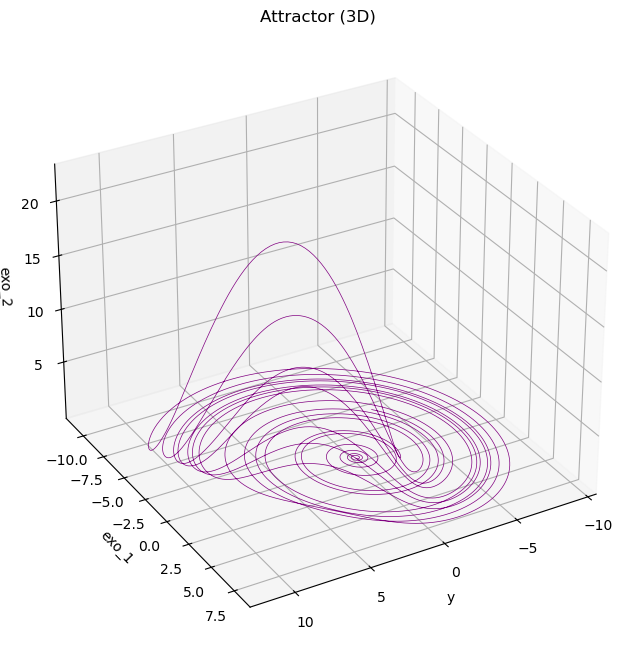

In [27]:
plot_3d(df0)

In [28]:
import matplotlib.pyplot as plt

def plot_all_samples_3d(samples_dict, colors=None):
    """
    Plot all 3D trajectories from a dictionary of DataFrames.
    
    Args:
        samples_dict (dict): {sample_name: DataFrame with 3 columns ['y', 'exo_1', 'exo_2']}
        colors (list): Optional list of colors for the trajectories.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Default colors if not provided
    default_colors = ['purple', 'orange', 'green', 'red', 'blue', 'brown', 'pink', 'cyan']
    if colors is None:
        colors = default_colors * ((len(samples_dict) // len(default_colors)) + 1)

    # Plot each sample
    for i, (name, df) in enumerate(samples_dict.items()):
        ax.plot(df['y'], df['exo_1'], df['exo_2'], color=colors[i], lw=0.5, label=name)

    ax.set_xlabel('y')
    ax.set_ylabel('exo_1')
    ax.set_zlabel('exo_2')
    ax.set_title('Rossler Trajectories (3D)')
    ax.view_init(elev=30, azim=60)
    ax.legend()
    plt.show()


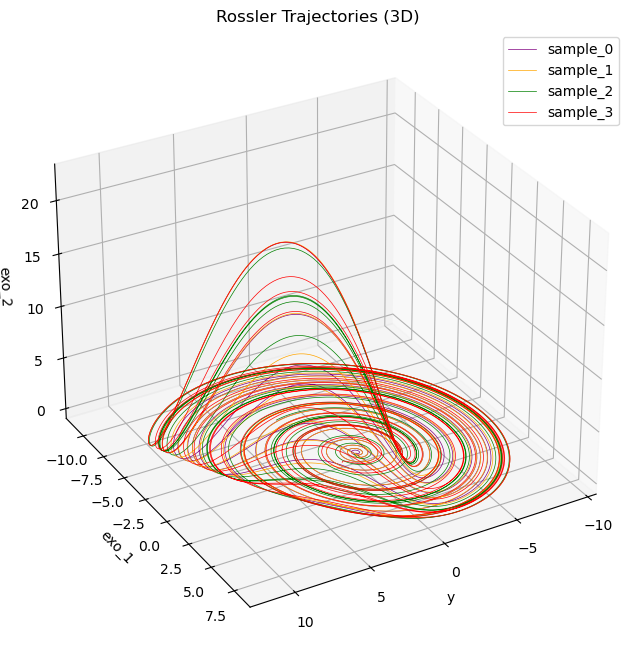

In [29]:
# Load all Rossler samples
rossler_samples = load_samples(exp_folder, "rossler")

# Plot them all in one figure
plot_all_samples_3d(rossler_samples)